In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import math

In [3]:

gamma = .5  # gradient scale
lens = 0.3

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=1):
    alpha = tau_m
    
    # ro = tau_adp

    # if isAdapt:
    #     beta = 1.8
    # else:
    #     beta = 0.

    # b = ro * b + (1 - ro) * spike
    # B = b_j0 + beta * b
    B = 1.


    d_mem = -mem + inputs
    mem = mem + d_mem*alpha
    inputs_ = mem - B

    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    mem = (1-spike)*mem

    return mem, spike, B, b

In [4]:
class LTC_SNN_rec_cell(nn.Module):
    def __init__(self, input_size, hidden_size,is_rec = False):
        super(LTC_SNN_rec_cell, self).__init__()
        # print('SNN-ltc ')
    
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.is_rec = is_rec

        if is_rec:
            self.layer1_x = nn.Linear(input_size+hidden_size, hidden_size)
        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)
        self.layer1_tauAdp = nn.Linear(2*hidden_size, hidden_size)
        self.layer1_tauM = nn.Linear(2*hidden_size, hidden_size)

        self.act1 = nn.Sigmoid()
        # nn.init.xavier_uniform_(self.layer1_x.weight)
        # nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
        # nn.init.xavier_uniform_(self.layer1_tauM.weight)

        nn.init.ones_(self.layer1_x.weight)
        nn.init.ones_(self.layer1_tauAdp.weight)
        nn.init.ones_(self.layer1_tauM.weight)

        nn.init.zeros_(self.layer1_x.bias)
        nn.init.zeros_(self.layer1_tauAdp.bias)
        nn.init.zeros_(self.layer1_tauM.bias)

    def forward(self, x_t, mem_t,spk_t,b_t):    
        if self.is_rec:
            dense_x = self.layer1_x(torch.cat((x_t,spk_t),dim=-1))
        else:
            dense_x = self.layer1_x(x_t)
        tauM1 = self.act1(self.layer1_tauM(torch.cat((dense_x,mem_t),dim=-1)))
        tauAdp1 = self.act1(self.layer1_tauAdp(torch.cat((dense_x,b_t),dim=-1)))
        

        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1,tauM1

    def compute_output_size(self):
        return [self.hidden_size]

In [5]:
class LTC_SNN_rec_cell(nn.Module):
    def __init__(self, input_size, hidden_size,is_rec = False):
        super(LTC_SNN_rec_cell, self).__init__()
        # print('SNN-ltc ')
    
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.is_rec = is_rec

        if is_rec:
            self.layer1_x = nn.Linear(input_size+hidden_size, hidden_size)
        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)
        self.layer1_tauAdp = nn.Linear(hidden_size, hidden_size)
        self.layer1_tauM = nn.Linear(hidden_size, hidden_size)

        self.act1 = nn.Sigmoid()
        # nn.init.xavier_uniform_(self.layer1_x.weight)
        # nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
        # nn.init.xavier_uniform_(self.layer1_tauM.weight)

        nn.init.ones_(self.layer1_x.weight)
        nn.init.ones_(self.layer1_tauAdp.weight)
        nn.init.ones_(self.layer1_tauM.weight)

        nn.init.zeros_(self.layer1_x.bias)
        nn.init.constant_(self.layer1_tauAdp.bias,-5.)
        nn.init.constant_(self.layer1_tauM.bias,-5.)

    def forward(self, x_t, mem_t,spk_t,b_t):    
        if self.is_rec:
            dense_x = self.layer1_x(torch.cat((x_t,spk_t),dim=-1))
        else:
            dense_x = self.layer1_x(x_t)
        tauM1 = self.act1(self.layer1_tauM(dense_x+mem_t))
        tauAdp1 = self.act1(self.layer1_tauAdp(dense_x+b_t))
        

        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1,tauM1

    def compute_output_size(self):
        return [self.hidden_size]

In [6]:
class SNN_rec_cell(nn.Module):
    def __init__(self, input_size, hidden_size,is_rec = False):
        super(SNN_rec_cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.is_rec = is_rec

        if is_rec:
            self.layer1_x = nn.Linear(input_size+hidden_size, hidden_size)
        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)

        self.tau_adp = nn.Parameter(torch.Tensor(hidden_size))
        self.tau_m =nn.Parameter(torch.Tensor(hidden_size))
        self.act1 = nn.Sigmoid()

        nn.init.constant_(self.tau_adp, 4.6)
        nn.init.constant_(self.tau_m, 0.)
        # nn.init.xavier_uniform_(self.layer1_x.weight)
        nn.init.ones_(self.layer1_x.weight)
        nn.init.zeros_(self.layer1_x.bias)

    def forward(self, x_t, mem_t,spk_t,b_t):    
        if self.is_rec:
            dense_x = self.layer1_x(torch.cat((x_t,spk_t),dim=-1))
        else:
            dense_x = self.layer1_x(x_t)
        tauM1 = self.act1(self.tau_m)
        tauAdp1 = self.act1(self.tau_adp)
        
        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1

    def compute_output_size(self):
        return [self.hidden_size]

In [7]:
ltc_snn = LTC_SNN_rec_cell(1,2)
snn = SNN_rec_cell(1,2)

In [8]:
# is_noise = 1.

In [9]:
T = 500
x = torch.zeros(T).view(1,1,T)

# x = torch.stack([torch.sin(torch.arange(0,5,1./T).float()*math.pi/.3)/5.+.2,
#                   torch.cos(torch.arange(1,6,1./T).float()*math.pi/.8)/10.+.1,
#                   torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.)/2.+.5]).view(1,3,500)

# x = x/5.
x[:,:,100:200] = 1.
x[:,:,300:400] = 1.1
x.shape

torch.Size([1, 1, 500])

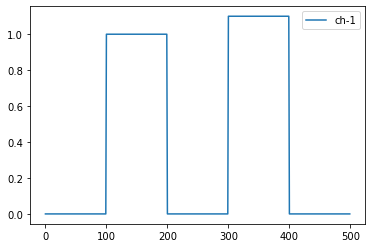

In [10]:
plt.plot(x.detach().cpu().numpy()[0,0,:],label='ch-1')
# plt.plot(x.detach().cpu().numpy()[0,1,:],label='ch-2')
# plt.plot(x.detach().cpu().numpy()[0,2,:],label='ch-3')
# plt.plot(x.detach().cpu().numpy().sum(1)[0],label='sum')

plt.legend()

In [11]:
mem_snn = torch.zeros(1,2)
spk_snn = torch.zeros(1,2)
b_snn = torch.zeros(1,2)

mem_ltc = torch.zeros(1,2)
spk_ltc = torch.zeros(1,2)
b_ltc = torch.zeros(1,2)

In [12]:
def plot_spk(spk_list,shape='*',label='spk',baseline=0.):
    spk_t = np.where(spk_list==1)[0]
    plt.plot(spk_t,np.ones(len(spk_t))+baseline,shape,label=label)

In [13]:
mem_ltc_list= []
spk_ltc_list= []
tauM_ltc_list = []

mem_snn_list= []
spk_snn_list= []
mem_ltc_list.append(mem_ltc.detach().numpy())
spk_ltc_list.append(spk_ltc.detach().numpy())
mem_snn_list.append(mem_snn.detach().numpy())
spk_snn_list.append(spk_snn.detach().numpy())

for i in range(500):
    mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
    mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
    tauM_ltc_list.append(tau_ltc.detach().numpy())
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

In [14]:
mem_ltc_np = np.array(mem_ltc_list)
spk_ltc_np = np.array(spk_ltc_list)
tau_ltc_np = np.array(tauM_ltc_list)

mem_snn_np = np.array(mem_snn_list)
spk_snn_np = np.array(spk_snn_list)

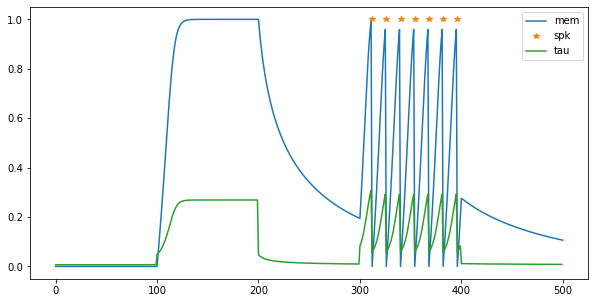

In [15]:
# mem_ltc_np.shape
plt.figure(figsize=(10,5))
plt.plot(mem_ltc_np[:,0,1],label='mem')
plot_spk(spk_ltc_np[:,0,1])
plt.plot(tau_ltc_np[:,0,1],label='tau')
plt.legend()

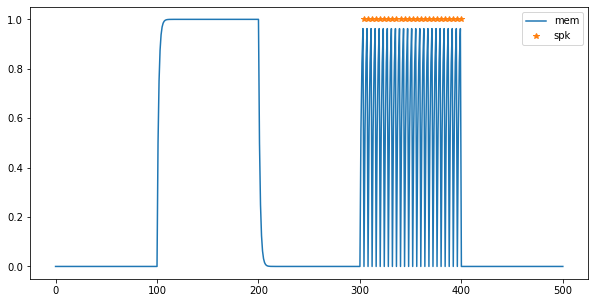

In [16]:
plt.figure(figsize=(10,5))
plt.plot(mem_snn_np[:,0,0],label='mem')
plot_spk(spk_snn_np[:,0,1])
plt.legend()

## add zeros

In [17]:
# T = 100
# x = torch.stack([torch.sin(torch.arange(0,5,1./T).float()*math.pi/.3)/5.+.2*torch.rand(500),
#                   torch.cos(torch.arange(1,6,1./T).float()*math.pi/.8)/10.+.1*torch.rand(500),
#                   torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.)/2.+.3]).view(1,3,500)

# # x = torch.stack([torch.sin(torch.arange(0,5,1./T).float()*math.pi/.3)/5.+.2,
# #                   torch.cos(torch.arange(1,6,1./T).float()*math.pi/.8)/10.+.1,
# #                   torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.)/2.+.3]).view(1,3,500)

# x[:,0,:] = x[:,0,:]*torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.).gt(0).float()
# x[:,2,:] = x[:,2,:]*torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.).gt(0).float()
# x.shape
T = 500
x = torch.zeros(T).view(1,1,T)

# x = torch.stack([torch.sin(torch.arange(0,5,1./T).float()*math.pi/.3)/5.+.2,
#                   torch.cos(torch.arange(1,6,1./T).float()*math.pi/.8)/10.+.1,
#                   torch.cos(torch.arange(3,8,1./T).float()*math.pi/1.)/2.+.5]).view(1,3,500)

# x = x/5.
x[:,:,50:200] = 1.+ 0.5*(torch.rand(150)-.5)
x[:,:,200:350] = 1. + 0.2*(torch.rand(150)-.5)
x[:,:,350:500] = 1. + 0.5*(torch.rand(150)-.5)

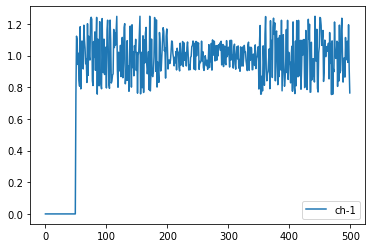

In [18]:
plt.plot(x.detach().cpu().numpy()[0,0,:],label='ch-1')
# plt.plot(x.detach().cpu().numpy()[0,1,:],label='ch-2')
# plt.plot(x.detach().cpu().numpy()[0,2,:],label='ch-3')
plt.legend()

In [19]:
mem_snn = torch.zeros(1,2)
spk_snn = torch.zeros(1,2)
b_snn = torch.zeros(1,2)

mem_ltc = torch.zeros(1,2)
spk_ltc = torch.zeros(1,2)
b_ltc = torch.zeros(1,2)

mem_ltc_list= []
spk_ltc_list= []
tauM_ltc_list = []

mem_snn_list= []
spk_snn_list= []
mem_ltc_list.append(mem_ltc.detach().numpy())
spk_ltc_list.append(spk_ltc.detach().numpy())
mem_snn_list.append(mem_snn.detach().numpy())
spk_snn_list.append(spk_snn.detach().numpy())

for i in range(500):
    mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
    mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
    tauM_ltc_list.append(tau_ltc.detach().numpy())
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

mem_ltc_np = np.array(mem_ltc_list)
spk_ltc_np = np.array(spk_ltc_list)
tau_ltc_np = np.array(tauM_ltc_list)

mem_snn_np = np.array(mem_snn_list)
spk_snn_np = np.array(spk_snn_list)

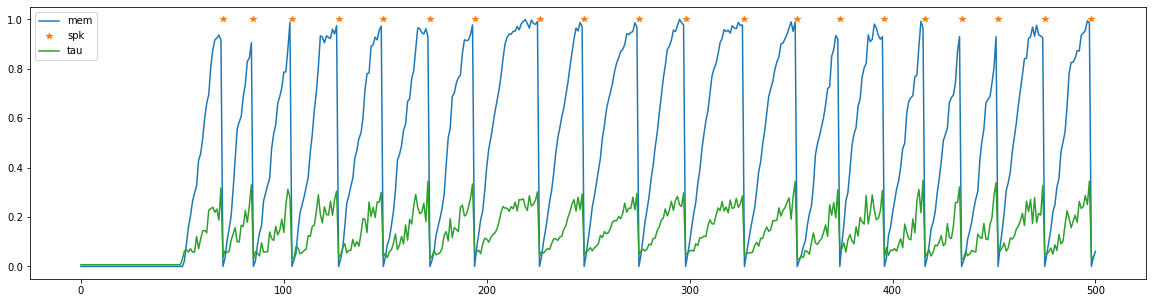

In [20]:
plt.figure(figsize=(20,5))
plt.plot(mem_ltc_np[:,0,1],label='mem')
plot_spk(spk_ltc_np[:,0,1])
plt.plot(tau_ltc_np[:,0,1],label='tau')
plt.legend()

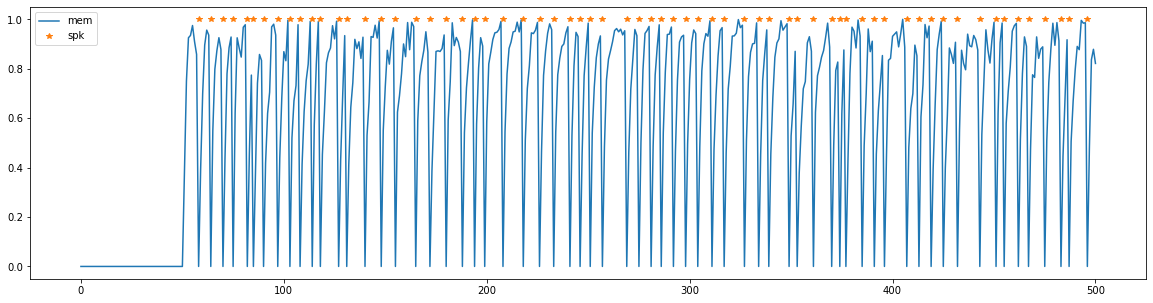

In [21]:
plt.figure(figsize=(20,5))
plt.plot(mem_snn_np[:,0,0],label='mem')
plot_spk(spk_snn_np[:,0,1])
plt.legend()

In [22]:
torch.sigmoid(torch.tensor([2.]))

tensor([0.8808])

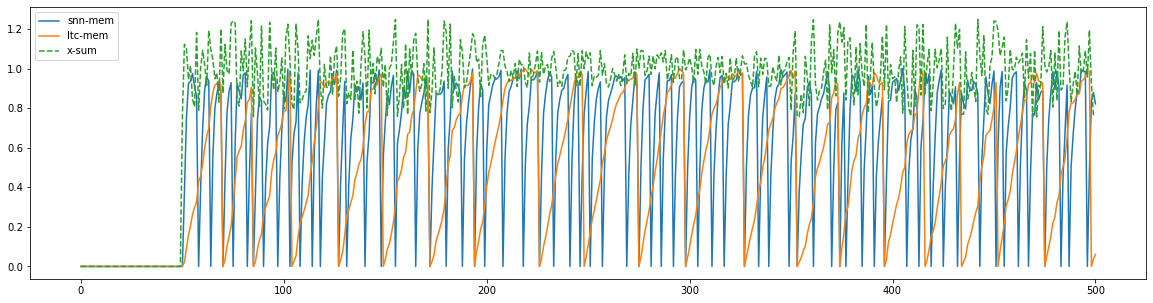

In [23]:
plt.figure(figsize=(20,5))
plt.plot(mem_snn_np[:,0,0],label='snn-mem')
plt.plot(mem_ltc_np[:,0,1],label='ltc-mem')
plt.plot(x.detach().cpu().numpy().sum(1)[0],'--',label='x-sum')
plt.legend()

## FI curve


In [24]:
T = 500
mean_fr_ltc = []
mean_fr_snn = []
for s in range(40):
    x= 1.+ s/20.*(torch.rand(T).view(1,1,T)-.5)

    mem_snn = torch.zeros(1,2)
    spk_snn = torch.zeros(1,2)
    b_snn = torch.zeros(1,2)

    mem_ltc = torch.zeros(1,2)
    spk_ltc = torch.zeros(1,2)
    b_ltc = torch.zeros(1,2)

    mem_ltc_list= []
    spk_ltc_list= []
    tauM_ltc_list = []

    mem_snn_list= []
    spk_snn_list= []
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

    for i in range(500):
        mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
        mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
        tauM_ltc_list.append(tau_ltc.detach().numpy())
        mem_ltc_list.append(mem_ltc.detach().numpy())
        spk_ltc_list.append(spk_ltc.detach().numpy())
        mem_snn_list.append(mem_snn.detach().numpy())
        spk_snn_list.append(spk_snn.detach().numpy())

    mem_ltc_np = np.array(mem_ltc_list)
    spk_ltc_np = np.array(spk_ltc_list)
    tau_ltc_np = np.array(tauM_ltc_list)

    mem_snn_np = np.array(mem_snn_list)
    spk_snn_np = np.array(spk_snn_list)

    print('ltc fr: ',np.mean(spk_ltc_np),'ltc fr: ',np.mean(spk_snn_np))
    mean_fr_ltc.append(np.mean(spk_ltc_np))
    mean_fr_snn.append(np.mean(spk_snn_np))

ltc fr:  0.0 ltc fr:  0.0
ltc fr:  0.029940119 ltc fr:  0.1017964
ltc fr:  0.033932135 ltc fr:  0.1237525
ltc fr:  0.033932135 ltc fr:  0.11776447
ltc fr:  0.033932135 ltc fr:  0.12774451
ltc fr:  0.03992016 ltc fr:  0.14570858
ltc fr:  0.03992016 ltc fr:  0.14570858
ltc fr:  0.03992016 ltc fr:  0.14171657
ltc fr:  0.04191617 ltc fr:  0.15568863
ltc fr:  0.045908183 ltc fr:  0.16367266
ltc fr:  0.047904193 ltc fr:  0.17165668
ltc fr:  0.0499002 ltc fr:  0.16167665
ltc fr:  0.051896207 ltc fr:  0.1736527
ltc fr:  0.053892214 ltc fr:  0.1736527
ltc fr:  0.055888224 ltc fr:  0.16966067
ltc fr:  0.053892214 ltc fr:  0.17165668
ltc fr:  0.051896207 ltc fr:  0.16966067
ltc fr:  0.059880238 ltc fr:  0.18363273
ltc fr:  0.05788423 ltc fr:  0.17165668
ltc fr:  0.05788423 ltc fr:  0.18363273
ltc fr:  0.063872255 ltc fr:  0.19760479
ltc fr:  0.07385229 ltc fr:  0.21556886
ltc fr:  0.06786427 ltc fr:  0.1996008
ltc fr:  0.07385229 ltc fr:  0.19760479
ltc fr:  0.075848304 ltc fr:  0.21756487
ltc fr

Text(0.5, 0, 'sigma')

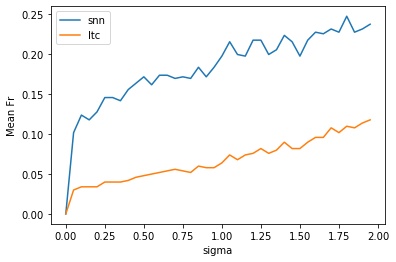

In [25]:
plt.plot(np.arange(40)/20.,mean_fr_snn,label='snn')
plt.plot(np.arange(40)/20.,mean_fr_ltc,label='ltc')
plt.legend()
plt.ylabel('Mean Fr')
plt.xlabel('sigma')

In [26]:
T = 500
mean_fr_ltc = []
mean_fr_snn = []
for s in range(50):
    x= 1.+s/50. + .1*(torch.rand(T).view(1,1,T)-0.5)

    mem_snn = torch.zeros(1,2)
    spk_snn = torch.zeros(1,2)
    b_snn = torch.zeros(1,2)

    mem_ltc = torch.zeros(1,2)
    spk_ltc = torch.zeros(1,2)
    b_ltc = torch.zeros(1,2)

    mem_ltc_list= []
    spk_ltc_list= []
    tauM_ltc_list = []

    mem_snn_list= []
    spk_snn_list= []
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

    for i in range(500):
        mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
        mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
        tauM_ltc_list.append(tau_ltc.detach().numpy())
        mem_ltc_list.append(mem_ltc.detach().numpy())
        spk_ltc_list.append(spk_ltc.detach().numpy())
        mem_snn_list.append(mem_snn.detach().numpy())
        spk_snn_list.append(spk_snn.detach().numpy())

    mem_ltc_np = np.array(mem_ltc_list)
    spk_ltc_np = np.array(spk_ltc_list)
    tau_ltc_np = np.array(tauM_ltc_list)

    mem_snn_np = np.array(mem_snn_list)
    spk_snn_np = np.array(spk_snn_list)

    print(s,' ==>ltc fr: ',np.mean(spk_ltc_np),'ltc fr: ',np.mean(spk_snn_np))
    mean_fr_ltc.append(np.mean(spk_ltc_np))
    mean_fr_snn.append(np.mean(spk_snn_np))

0  ==>ltc fr:  0.033932135 ltc fr:  0.11377245
1  ==>ltc fr:  0.043912176 ltc fr:  0.15369262
2  ==>ltc fr:  0.0499002 ltc fr:  0.18762475
3  ==>ltc fr:  0.055888224 ltc fr:  0.20958084
4  ==>ltc fr:  0.063872255 ltc fr:  0.23952095
5  ==>ltc fr:  0.06786427 ltc fr:  0.247505
6  ==>ltc fr:  0.07385229 ltc fr:  0.25948104
7  ==>ltc fr:  0.07984032 ltc fr:  0.27944112
8  ==>ltc fr:  0.08582834 ltc fr:  0.31137726
9  ==>ltc fr:  0.08982036 ltc fr:  0.33133733
10  ==>ltc fr:  0.09780439 ltc fr:  0.33133733
11  ==>ltc fr:  0.1017964 ltc fr:  0.33133733
12  ==>ltc fr:  0.10978044 ltc fr:  0.33133733
13  ==>ltc fr:  0.11776447 ltc fr:  0.33133733
14  ==>ltc fr:  0.1237525 ltc fr:  0.33133733
15  ==>ltc fr:  0.12974052 ltc fr:  0.33932135
16  ==>ltc fr:  0.13972056 ltc fr:  0.36926147
17  ==>ltc fr:  0.14371258 ltc fr:  0.41516966
18  ==>ltc fr:  0.1497006 ltc fr:  0.4750499
19  ==>ltc fr:  0.16367266 ltc fr:  0.499002
20  ==>ltc fr:  0.16566867 ltc fr:  0.499002
21  ==>ltc fr:  0.16966067 ltc

Text(0.5, 0, 'sigma')

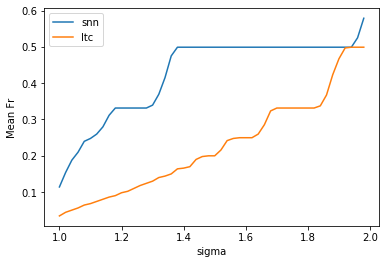

In [27]:
plt.plot(1+np.arange(50)/50.,mean_fr_snn,label='snn')
plt.plot(1+np.arange(50)/50.,mean_fr_ltc,label='ltc')
plt.legend()
plt.ylabel('Mean Fr')
plt.xlabel('sigma')

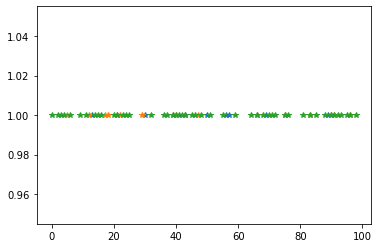

In [28]:
plot_spk(torch.bernoulli(torch.ones(100)*.1).numpy())
plot_spk(torch.bernoulli(torch.ones(100)*.2).numpy())
plot_spk(torch.bernoulli(torch.ones(100)*.5).numpy())

In [29]:
T = 1000
mean_fr_ltc = []
mean_fr_snn = []
for s in range(50):
    # x= 1.+s/50. + .1*(torch.rand(T).view(1,1,T)-0.5)
    x = torch.bernoulli(torch.ones(T)*s/50.).view(1,1,T)*1.1

    mem_snn = torch.zeros(1,2)
    spk_snn = torch.zeros(1,2)
    b_snn = torch.zeros(1,2)

    mem_ltc = torch.zeros(1,2)
    spk_ltc = torch.zeros(1,2)
    b_ltc = torch.zeros(1,2)

    mem_ltc_list= []
    spk_ltc_list= []
    tauM_ltc_list = []

    mem_snn_list= []
    spk_snn_list= []
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

    for i in range(T):
        mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
        mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
        tauM_ltc_list.append(tau_ltc.detach().numpy())
        mem_ltc_list.append(mem_ltc.detach().numpy())
        spk_ltc_list.append(spk_ltc.detach().numpy())
        mem_snn_list.append(mem_snn.detach().numpy())
        spk_snn_list.append(spk_snn.detach().numpy())

    mem_ltc_np = np.array(mem_ltc_list)
    spk_ltc_np = np.array(spk_ltc_list)
    tau_ltc_np = np.array(tauM_ltc_list)

    mem_snn_np = np.array(mem_snn_list)
    spk_snn_np = np.array(spk_snn_list)

    print(s,' ==>ltc fr: ',np.mean(spk_ltc_np),'ltc fr: ',np.mean(spk_snn_np))
    mean_fr_ltc.append(np.mean(spk_ltc_np))
    mean_fr_snn.append(np.mean(spk_snn_np))

0  ==>ltc fr:  0.0 ltc fr:  0.0
1  ==>ltc fr:  0.0 ltc fr:  0.0
2  ==>ltc fr:  0.0 ltc fr:  0.0
3  ==>ltc fr:  0.0 ltc fr:  0.0
4  ==>ltc fr:  0.0 ltc fr:  0.0
5  ==>ltc fr:  0.0 ltc fr:  0.0
6  ==>ltc fr:  0.0 ltc fr:  0.0
7  ==>ltc fr:  0.0 ltc fr:  0.0
8  ==>ltc fr:  0.0 ltc fr:  0.001998002
9  ==>ltc fr:  0.000999001 ltc fr:  0.000999001
10  ==>ltc fr:  0.0 ltc fr:  0.0
11  ==>ltc fr:  0.000999001 ltc fr:  0.002997003
12  ==>ltc fr:  0.002997003 ltc fr:  0.003996004
13  ==>ltc fr:  0.001998002 ltc fr:  0.001998002
14  ==>ltc fr:  0.003996004 ltc fr:  0.007992008
15  ==>ltc fr:  0.006993007 ltc fr:  0.010989011
16  ==>ltc fr:  0.004995005 ltc fr:  0.006993007
17  ==>ltc fr:  0.005994006 ltc fr:  0.005994006
18  ==>ltc fr:  0.011988012 ltc fr:  0.02097902
19  ==>ltc fr:  0.012987013 ltc fr:  0.015984016
20  ==>ltc fr:  0.016983017 ltc fr:  0.022977022
21  ==>ltc fr:  0.018981019 ltc fr:  0.032967035
22  ==>ltc fr:  0.016983017 ltc fr:  0.02897103
23  ==>ltc fr:  0.022977022 ltc fr:  

Text(0.5, 0, 'rate')

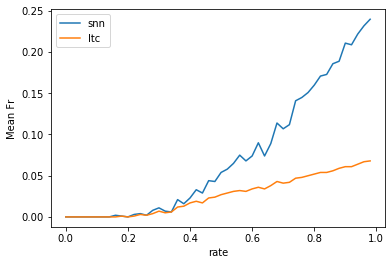

In [30]:
plt.plot(np.arange(50)/50.,mean_fr_snn,label='snn')
plt.plot(np.arange(50)/50.,mean_fr_ltc,label='ltc')
plt.legend()
plt.ylabel('Mean Fr')
plt.xlabel('rate')

49  ==>ltc fr:  0.017982017 ltc fr:  0.007992008


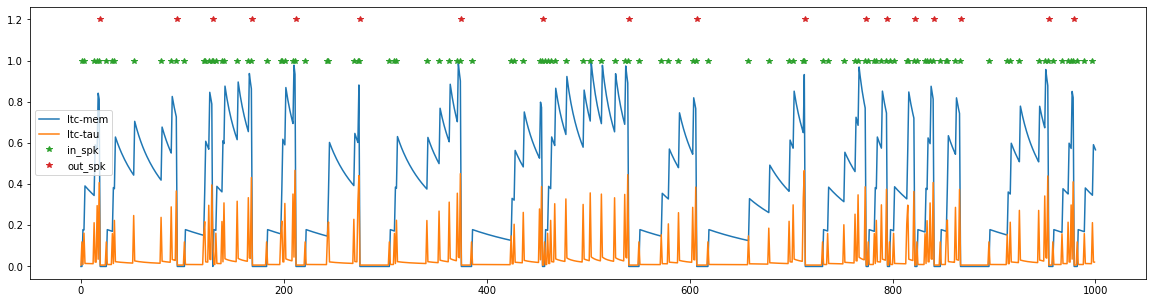

In [31]:
x_t = torch.bernoulli(torch.ones(T)*.1).view(1,1,T)
x = x_t*1.5

mem_snn = torch.zeros(1,2)
spk_snn = torch.zeros(1,2)
b_snn = torch.zeros(1,2)

mem_ltc = torch.zeros(1,2)
spk_ltc = torch.zeros(1,2)
b_ltc = torch.zeros(1,2)

mem_ltc_list= []
spk_ltc_list= []
tauM_ltc_list = []

mem_snn_list= []
spk_snn_list= []
mem_ltc_list.append(mem_ltc.detach().numpy())
spk_ltc_list.append(spk_ltc.detach().numpy())
mem_snn_list.append(mem_snn.detach().numpy())
spk_snn_list.append(spk_snn.detach().numpy())

for i in range(T):
    mem_ltc,spk_ltc,b_ltc,tau_ltc = ltc_snn(x[:,:,i],mem_ltc,spk_ltc,b_ltc)
    mem_snn,spk_snn,b_snn = snn(x[:,:,i],mem_snn,spk_snn,b_snn)
    tauM_ltc_list.append(tau_ltc.detach().numpy())
    mem_ltc_list.append(mem_ltc.detach().numpy())
    spk_ltc_list.append(spk_ltc.detach().numpy())
    mem_snn_list.append(mem_snn.detach().numpy())
    spk_snn_list.append(spk_snn.detach().numpy())

mem_ltc_np = np.array(mem_ltc_list)
spk_ltc_np = np.array(spk_ltc_list)
tau_ltc_np = np.array(tauM_ltc_list)

mem_snn_np = np.array(mem_snn_list)
spk_snn_np = np.array(spk_snn_list)

print(s,' ==>ltc fr: ',np.mean(spk_ltc_np),'ltc fr: ',np.mean(spk_snn_np))


plt.figure(figsize=(20,5))
# plt.plot(mem_snn_np[:,0,0],label='snn-mem')
plt.plot(mem_ltc_np[:,0,1],label='ltc-mem')
plt.plot(tau_ltc_np[:,0,1],label='ltc-tau')
plot_spk(x_t.detach().numpy()[0,0,],label='in_spk')
plot_spk(spk_ltc_np[:,0,1],label='out_spk',baseline=.2)
plt.legend()

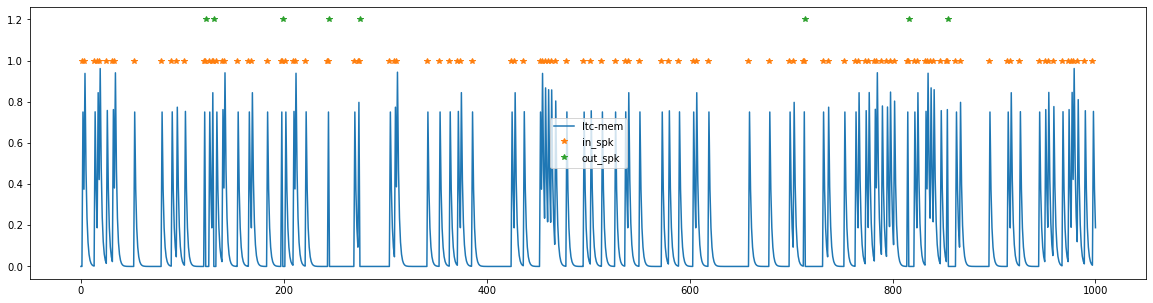

In [32]:
plt.figure(figsize=(20,5))
# plt.plot(mem_snn_np[:,0,0],label='snn-mem')
plt.plot(mem_snn_np[:,0,1],label='ltc-mem')
plot_spk(x_t.detach().numpy()[0,0,],label='in_spk')
plot_spk(spk_snn_np[:,0,1],label='out_spk',baseline=.2)
plt.legend()